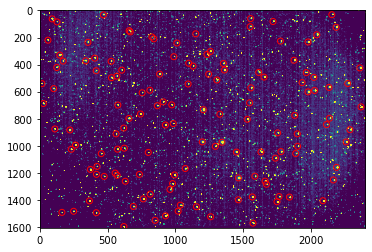

In [92]:
# Compute MAD of the background
bkg_mad = DataFrame(b_data).mad(skipna = True)

# Find the sources
daofind = DAOStarFinder(threshold = 3*bkg_mad, fwhm = 4)
sources = daofind(b_data)

# Plot the sources with red circles
plt.imshow(b_data, vmin = np.median(b_data), vmax = np.median(b_data) + 100)
plt.scatter(sources['xcentroid'], sources['ycentroid'], facecolor = 'none', edgecolor = 'red')

In [93]:
def profiles(data, xcenter, ycenter):

    '''
    PURPOSE:
            This function returns the horizontal and vertical profiles of the data.

    INPUTS:
            [data; np.array, float]:  The data to be bias subtracted.
            [xcenter; float]: The x coordinate of the star.
            [ycenter; float]: The y coordinate of the star.

    OUTPUTS:
            [x; np.array, float]: The horizontal profile.
            [y; np.array, float]: The vertical profile.
    '''

    # Get the horizontal profile
    ypix, xpix = ycenter, xcenter

    # Get the vertical profile
    x = np.take(data, ypix, axis = 0)[int(xcenter) - 25:int(xcenter) + 25]
    y = np.take(data, xpix, axis = 1)[int(ycenter) - 25:int(ycenter) + 25]

    return x, y

def interpolate_width(axis, background):

    '''
    PURPOSE:
            This function interpolates the width of the data.

    INPUTS:
            [axis; np.array, float]:  The horizontal or vertical profile.
                [background; float]:  The background level of the data.

    OUTPUTS:
                 [r1; float]: The left root.
                 [r2; float]: The right root.
            [r2 - r1; float]: The FWHM.
    '''

    # Get the peak
    peak = axis.max()

    # Get the half max
    half_max = (peak - background)/2

    # Get the x values
    x = np.linspace(0, len(axis), len(axis))

    # Do the interpolation
    spline = UnivariateSpline(x, axis - background - half_max, s = 0)

    # Get the roots
    r1, r2 = spline.roots()

    return r1, r2, r2 - r1

def GetFWHM(data, sources, makeplot):

    '''
    PURPOSE:
            This function calculates the FWHM of the data.

    INPUTS:
               [data; np.array, float]:  The data to be bias subtracted.
            [sources; np.array, float]:  The sources found in the data.
                      [makeplot; bool]:  Whether or not to make a plot.

    OUTPUTS:
            [median_FWHM; float]: The median FWHM of the data.
    '''    

    # Get the background
    mean, median, std = sigma_clipped_stats(data, sigma = 3.0)

    # Set the background
    background = median
       
    # Get the x and y coordinates
    xlist = (np.array(sources['xcentroid']))
    ylist = (np.array(sources['ycentroid']))
    
    # Get the centroids
    xlist, ylist = centroid_sources(data, xlist, ylist, box_size = 25, centroid_func = centroid_com)
    
    # Make empty array to store FWHMs
    FWHM = []

    # Loop over sources
    for ID in range(len(xlist)):

        # Get the x and y centers
        xcenter, ycenter = xlist[ID], ylist[ID]
        
        try:

            # Get the horizontal and vertical profiles
            horizontal, vertical = profiles(data, xcenter, ycenter)

            # Interpolate the width     
            r1h, r2h, fwhm_x = interpolate_width(horizontal, background)
            r1v, r2v, fwhm_y = interpolate_width(vertical, background)

            # Get the FWHM         
            fwhm_inst = np.mean([fwhm_x, fwhm_y])

            # Append the FWHM
            FWHM = np.append(FWHM, fwhm_inst)
            

            # Check if plot should be made
            if makeplot == True:

                # Make range for x axis
                xx = np.arange(0, len(vertical), 1)

                # Get the half max
                hor_half = ((horizontal - background).max())/2
                ver_half = ((vertical - background).max())/2

                # Make plot
                fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (10, 4))
                
                ax1.imshow(data[int(ycenter) - 25:int(ycenter) + 25, int(xcenter) - 25:int(xcenter) + 25], norm = LogNorm(), origin = 'lower')
                ax1.axvline(25, color = 'red', linestyle = 'dashed', alpha = 0.8)
                ax1.axhline(25, color = 'red', linestyle = 'dashed', alpha = 0.8)
                
                ax2.plot(xx,vertical - background)
                ax2.hlines(ver_half, color = 'red', xmin = r1v, xmax = r2v)
                ax2.set_title('Vertical Cross Section')
                ax2.set_xlabel('FWHM= ' + str(np.round(fwhm_y, 2)))
                
                ax3.plot(xx,horizontal - background)
                ax3.set_title('Horizontal Cross Section')
                ax3.hlines(hor_half, color = 'red', xmin = r1h, xmax = r2h)
                ax3.set_title('Horizontal Cross Section')
                ax3.set_xlabel('FWHM= ' + str(np.round(fwhm_x, 2)))                
                plt.show()    
                #plt.savefig('FWHM example.pdf',bbox_inches='tight',facecolor='white')
        except:
            pass

    # Get the median FWHM 
    median_FWHM = np.median(FWHM)

    # Make histogram and save
    plt.hist(FWHM, bins = 'auto')
    plt.axvline(median_FWHM, color = 'red', linestyle = 'dashed')
    plt.xlabel(str(len(FWHM)) + ' FWHMs calculated \n Median FWHM: ' + str(np.round(median_FWHM, 2)), size = 13)
    plt.savefig('FWHM median.pdf', bbox_inches = 'tight',facecolor = 'white')
    print('Median FWHM: ' + str(np.round(median_FWHM, 2)))
    
    return median_FWHM

Median FWHM: 2.05


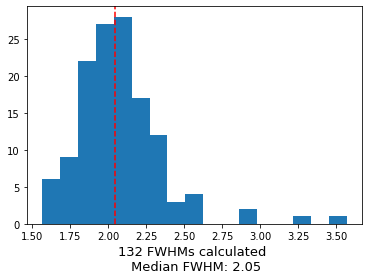

In [94]:
# Get the median FWHM
median_FWHM = GetFWHM(data = data, sources = sources, makeplot = False)

# Aperture Photometry

In [154]:


# Stack the coordinates
source_positions = np.column_stack((xcentroid, ycentroid))

# Make the apertures
aperture = CircularAperture(source_positions, r = 1.5*median_FWHM)
annulus = CircularAnnulus(source_positions, r_in = median_FWHM + 2, r_out = median_FWHM + 5)

# Store the apertures as a list
phot_aper = [aperture, annulus]

# Sigma clip the data
filtered_data = sigma_clip(data, sigma = 3., copy = False)

# Mask the data
bkg_values_nan = filtered_data.filled(fill_value = np.nan)

# Calculate the error on the background
bkg_error = np.sqrt(bkg_values_nan)

# Replace NaNs with median
bkg_error[np.isnan(bkg_error)] = np.nanmedian(bkg_error)

# Calculate the total error
unc_data = calc_total_error(data, bkg_error, effective_gain = 1) 

# Make the photometry table
phot_table = aperture_photometry(data, phot_aper, error = unc_data)

# Calculate the background
bkg_mean = phot_table['aperture_sum_1'] / annulus.area

# Calculate the background counts sum
bkg_ap_sum = bkg_mean * aperture.area

# Subtract the background
final_sum = phot_table['aperture_sum_0'] - bkg_ap_sum

# Store the background subtracted counts
phot_table['bg_subtracted_counts'] = final_sum

# Calculate the error on the background
bkg_mean_err = phot_table['aperture_sum_err_1'] / annulus.area

# Calculate the background counts sum error
bkg_sum_err = bkg_mean_err * aperture.area

# Calculate the background subtracted counts error
phot_table['bg_sub_cts_err'] = np.sqrt((phot_table['aperture_sum_err_0']**2)+(bkg_sum_err**2)) 

# Calculate the instrumental magnitude
phot_table['Instr_Mag'] = -2.5*np.log10(phot_table['bg_subtracted_counts']/header['EXPTIME'])

# Calculate the instrumental magnitude error
phot_table['Instr_Mag_err'] = np.abs((-5/(2*np.log(10)))*(header['EXPTIME']/phot_table['bg_subtracted_counts'])*phot_table['bg_sub_cts_err'])

In [155]:
# Display the table
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,bg_subtracted_counts,bg_sub_cts_err,Instr_Mag,Instr_Mag_err
,pix,pix,,,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,2155.6217665486756,31.496852535275465,63754.357109668905,304.19906367851235,229549.12907217623,677.3013077944889,34870.882302755446,315.9113686178598,-8.856157340075331,0.09836183880440513
2,469.5233543758807,32.70155318958849,129968.3607564296,398.4350810324567,232679.04241039205,681.5279545314183,100691.0583910428,407.55903441615743,-10.007477264669864,0.04394646419579699
3,1556.0299400606373,60.18957900893707,96093.11055151364,353.376942644005,232372.05443875276,680.8436014091816,66854.43555701127,363.6129192840819,-9.5628255661689,0.05905183518419823
4,91.3782393271801,62.570980602174544,168732.11791076223,444.42577665080694,232779.05258311756,680.6342840792857,139442.23156687798,452.6023094164477,-10.360985810997565,0.03524088134338947
5,1721.7424597202214,81.73278191364324,55279.827226676054,289.93444132697795,230403.70255112142,678.7887639303322,26288.82401549665,302.2529383304791,-8.549427897844492,0.1248313572134229
6,127.53791861145729,85.04231206400138,52532.44007815501,285.1571375909531,227760.35237546358,675.0215343025035,23874.04164972107,297.5377360572423,-8.44481486795973,0.13531328170523257
7,1552.9202396183719,120.35986273356403,87149.82302608815,340.48785010187794,231480.4679905963,680.1037934282391,58023.33366617128,351.0770952724672,-9.409006692726043,0.06569376299398501
8,2187.6595726347505,124.4978166517304,78823.34382526283,328.03276797627024,230306.8588079221,678.5434089777254,49844.52617030057,338.961771712894,-9.244043679710396,0.07383419922987099
